In [1]:
import emoji
#Import scikit-learn dataset library
import pandas as pd
#Text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords') 
#sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#Libraries for plotting
import seaborn as sns
#Modules for plotting
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point , Polygon
import descartes
#Import Nominatim for transform city names
from geopy.geocoders import Nominatim

In [2]:
#Load dataset
df = pd.read_csv('tweets.csv').set_index('id')
df

,keyword,location,text,target
id,,,,
0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0


In [3]:
# Applying a first round of text cleaning techniques to the text column

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function
df['text'] = df['text'].apply(lambda x: clean_text(x))

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['text'] = df['text'].apply(lambda x: deEmojify(x))
# I'm going to comment on this line that I think is the one who return an error
#df.convert_dtypes['location'] = df['location'].apply(lambda x: deEmojify(x))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,NaN,communal violence in bhainsa telangana stones ...,1
1,ablaze,NaN,telangana section has been imposed in bhainsa...,1
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1
3,ablaze,"Morgantown, WV",arsonist sets cars ablaze at dealership,1
4,ablaze,NaN,lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,media should have warned us well in advance th...,0
11366,wrecked,arohaonces,i feel directly attacked i consider moonbin a...,0
11367,wrecked,🇵🇭,i feel directly attacked i consider moonbin a...,0


## Cleaning the 'Keyword' column

In [4]:
#First we're going to check this column
df.keyword.describe()

count            11370
unique             219
top       thunderstorm
freq                93
Name: keyword, dtype: object

As we can see there are 219 unique values in this column, let's see what are those

In [5]:
# get all the unique values in the 'keyword' column
keywords = df['keyword'].unique()

# sort them alphabetically and then take a closer look
keywords.sort()
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'bush%20fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desol

As we can see the only characters that are unusual are "%20" ones, so we can replace them for an empty space.

In [6]:
#Remove the "%20" from the registers in the column 'keyword'
df['keyword'] = df['keyword'].apply(lambda x: x.replace("%20"," "))

#Change the dtype of the column from object to str
df.keyword = df.keyword.astype(str)

# get all the unique values in the 'keyword' column
keywords = df['keyword'].unique()

# sort them alphabetically and then take a closer look
keywords.sort()
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'bush fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desolate', 'desolation', 'destr

As we can see, the unique values still remain 219, but we successfully removed all the '%20' characters from our registers in the 'keyword' column.

# Transform the emoji flag to a string in the 'location' column

In [7]:
#Apply quotation marks to all registers in the "location" column (this will allowed us to treat the emoji flags later with the
# emoji library).
df.location = df.location.astype(str)
df.update(df[['location']].applymap('\'{}\''.format))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,'nan',communal violence in bhainsa telangana stones ...,1
1,ablaze,'nan',telangana section has been imposed in bhainsa...,1
2,ablaze,'New York City',arsonist sets cars ablaze at dealership,1
3,ablaze,"'Morgantown, WV'",arsonist sets cars ablaze at dealership,1
4,ablaze,'nan',lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,'Blue State in a red sea',media should have warned us well in advance th...,0
11366,wrecked,'arohaonces',i feel directly attacked i consider moonbin a...,0
11367,wrecked,'🇵🇭',i feel directly attacked i consider moonbin a...,0


In [8]:
#Transform the emoji flags in the location column 
def emojiflag_to_text(flag):
    '''Convert the emoji flag to a string with their name. the emoji flags are two unicode letters that composes 
    for example 🇲🇽 -> MX, so we know that the lenght of an emoji flag is 2, as we put it in a simple quotation marks, 
    we can assume that an emoji flag has lenght equal to 4'''
    if len(flag) == 4:
      return emoji.demojize(flag)
    else:
      return flag
     


# Applying the transform function
df['location'] = df['location'].apply(lambda x: emojiflag_to_text(x))

# Let's take a look at the updated text
df

,keyword,location,text,target
id,,,,
0,ablaze,'nan',communal violence in bhainsa telangana stones ...,1
1,ablaze,'nan',telangana section has been imposed in bhainsa...,1
2,ablaze,'New York City',arsonist sets cars ablaze at dealership,1
3,ablaze,"'Morgantown, WV'",arsonist sets cars ablaze at dealership,1
4,ablaze,'nan',lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,'Blue State in a red sea',media should have warned us well in advance th...,0
11366,wrecked,'arohaonces',i feel directly attacked i consider moonbin a...,0
11367,wrecked,':Philippines:',i feel directly attacked i consider moonbin a...,0


In [9]:
#Remove the simple quotes from all the registers in the "location" column.
df['location'] = df['location'].apply(lambda x: x.replace("'",""))

#Remove the ":" from the registers that used to be an emoji flag
df['location'] = df['location'].apply(lambda x: x.replace(":",""))

#Remove the strings nan with a true NaN
df['location'] = df['location'].apply(lambda x: x.replace("nan",""))

#Remove all the emojis (no emoji flags) that remains in the 'location' column
df['location'] = df['location'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

# Let's take a look at the updated text
df

<ipython-input-9-afbf02cf057b>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['location'] = df['location'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)


,keyword,location,text,target
id,,,,
0,ablaze,,communal violence in bhainsa telangana stones ...,1
1,ablaze,,telangana section has been imposed in bhainsa...,1
2,ablaze,New York City,arsonist sets cars ablaze at dealership,1
3,ablaze,"Morgantown, WV",arsonist sets cars ablaze at dealership,1
4,ablaze,,lord jesus your love brings freedom and pardon...,0
...,...,...,...,...
11365,wrecked,Blue State in a red sea,media should have warned us well in advance th...,0
11366,wrecked,arohaonces,i feel directly attacked i consider moonbin a...,0
11367,wrecked,Philippines,i feel directly attacked i consider moonbin a...,0


# Taking note of dataset issues
For the dataset Tweets we can see that only the column called location has missing values. We only have **7,952** locations of **11,370** Tweets.
And some emojis in text that we have to clean later on.

In [10]:
df.info()
print('\n')
print('Data Type')
print('__'*12)
df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11370 entries, 0 to 11369
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   11370 non-null  object
 1   location  11370 non-null  object
 2   text      11370 non-null  object
 3   target    11370 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 444.1+ KB


Data Type
________________________


keyword     object
location    object
text        object
target       int64
dtype: object

In [11]:
nul_locations = df['location'].isna().sum()
print(f'We have {nul_locations} missing locations')

We have 0 missing locations


In order to get the best data type to work with we can use `.convert_dtypes()` . To change the data type and have a better workflow

In [12]:
print('Data Type Converted')
print('__'*12)
df.convert_dtypes().dtypes

Data Type Converted
________________________


keyword     string
location    string
text        string
target       Int64
dtype: object

## Here we have another look.
*   219 unique keywords that describes the tweets
*   4,504 unique locations wich need to be grouped later on
*   11,223 Tweets (text) wich make us think if there is a kind of   duplicated message. 
*   And 2 different variables in target, 0 and 1 

In [13]:
# We use unique to know the different variables that conforms each column
df.nunique()

keyword       219
location     4445
text        10973
target          2
dtype: int64

In [14]:
# Let's see if there is any duplicated text
dup_text = df['text'].duplicated().sum()
print(f'We have {dup_text} duplicated texts')

We have 397 duplicated texts


In [15]:
# We can have a description of the lenght of the text, the largest and shortest text and maybe a relation with the target number. 
df['length'] = [len(i) for i in df['text']]
df['length'].describe()

count    11370.000000
mean        92.061214
std         29.160143
min          0.000000
25%         74.000000
50%        102.000000
75%        115.000000
max        139.000000
Name: length, dtype: float64

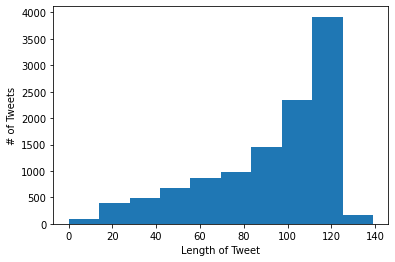

In [16]:
# Histogram with the distribution of the Tweets
plt.hist(df.length)
plt.xlabel('Length of Tweet')
plt.ylabel('# of Tweets')
plt.show()

In [17]:
# Table with the highest and lowest lengths
display(df[df['length']>130])
print('\n')
display(df[df['length']<20])

,keyword,location,text,target,length
id,,,,,
567,attack,,money website my pinned tweet so republicans l...,0,134
568,attack,,i love it when the possessed attack me on here...,0,133
685,avalanche,"Islamabad, Pakistan",breaking news at least people have been kille...,1,132
1003,bleeding,idk im bad at directions,my fatass just tripped on some shit in my room...,1,137
1261,bloody,"Canberra, ACT",sitting in the front room with my bride and th...,0,131
1918,burning,she/her,people that get really hot radiator hands do u...,0,138
2123,catastrophic,,if you sacrifice the president and the senate ...,0,134
2232,chemical emergency,BROKEN Hill,“culture isn’t something that can be drawn fro...,0,136
3261,debris,"Sherfield on Loddon, England",overnight course is very wet with the worst t...,0,131


,keyword,location,text,target,length
id,,,,,
80,aftershock,"Philippines ,From America",a other hard hit,0,17
303,annihilation,"Adelaide, South Australia",annihilation,0,13
336,apocalypse,"Lat Krabang, Bangkok",apocalypse,0,10
337,apocalypse,,…,0,2
348,apocalypse,"Brisbane, Australia",apocalypse chic,0,15
...,...,...,...,...,...
10940,weapons,"Baltimore, MD",still who sent…,0,16
10999,whirlwind,Lucky Landing,ok whirlwind,1,12
11002,whirlwind,,whirlwind,1,9


# Where do the Tweets come from?
We take a first look to the availables places that we have. We are getting the locations that occurs at least 10 times

In [18]:
location = df['location'].value_counts()
location[location>=10][:20]

                           3450
United States                97
Australia                    83
London, England              81
UK                           77
India                        74
London                       69
United Kingdom               59
USA                          52
California, USA              47
Los Angeles, CA              45
England, United Kingdom      39
Lagos, Nigeria               36
Nigeria                      36
Melbourne, Victoria          32
Ireland                      31
Earth                        31
Canada                       28
Philippines                  28
Mumbai, India                27
Name: location, dtype: int64

In [19]:
# We are going to group some places, so we create a mapping dictionary to replace the locations
mapping = {'United States':'USA',
          'New York':'USA',
          "London":'UK',
          "Los Angeles, CA":'USA',
          "Washington, D.C.":'USA',
          "California":'USA',
          "Chicago, IL":'USA',
          "Chicago":'USA',
          "New York, NY":'USA',
          "California, USA":'USA',
          "FLorida":'USA',
          "Nigeria":'Africa',
          "Kenya":'Africa',
          "Everywhere":'Worldwide',
          "San Francisco":'USA',
          "Florida":'USA',
          "United Kingdom":'UK',
          "Los Angeles":'USA',
          "Toronto":'Canada',
          "San Francisco, CA":'USA',
          "NYC":'USA',
          "Seattle":'USA',
          "Earth":'Worldwide',
          "Ireland":'UK',
          "London, England":'UK',
          "New York City":'USA',
          "Texas":'USA',
          "London, UK":'UK',
          "Atlanta, GA":'USA',
          "England, United Kingdom":'UK',
          "Mumbai, India":'India',
          "Melbourne,Victoria":'Australia'}

In [20]:
# We apply a function and change the name of the location to group if it exists on the mapping key
df['location'] = df['location'].apply(lambda i: mapping[i] if i in mapping.keys() else i)

In [21]:
# save df
df.to_csv('df_transform.csv', index=False)

In [22]:
# Now the values changed
ndf = df
ndf.dropna()
location = ndf['location'].value_counts()
location[location>=10]

                             3450
USA                           396
UK                            369
India                         101
Australia                      83
                             ... 
France                         10
Bangkok, Thailand              10
Brisbane, Queensland           10
Bristol, England               10
Belfast, Northern Ireland      10
Name: location, Length: 71, dtype: int64

In [23]:
localizator = Nominatim(user_agent='tweets-analysis') # Creation of the agent 

In [24]:
location = list(location.index) #We keep just the name of the cities

In [25]:
# geolocated = list(map(lambda x: [x,localizator.geocode(x,timeout=None)[1] if localizator.geocode(x,timeout=None) else None],location2))
# geolocated = pd.DataFrame(geolocated)
# geolocated.columns = ['locat','latlong']
# try:
#   geolocated['lat'] = geolocated.latlong.apply(lambda x: x[0])
#   geolocated['lon'] = geolocated.latlong.apply(lambda x: x[1])
#   geolocated.drop('latlong',axis=1, inplace=True)
# except:
#   pass

In [26]:
geolocated = pd.read_csv('coords.csv')

In [27]:
geolocated.drop(['Unnamed: 0','Unnamed: 0.1'],1,inplace=True)


In [28]:
geolocated['latlong']=geolocated.latlong.apply(lambda x: x[1:-1].split(','))

In [29]:
  geolocated['lat'] = geolocated.latlong.apply(lambda x: x[0])
  geolocated['lon'] = geolocated.latlong.apply(lambda x: x[1])
  geolocated.drop('latlong',axis=1, inplace=True)

In [30]:
geolocated['lat']=pd.to_numeric(geolocated['lat'])
geolocated['lon']=pd.to_numeric(geolocated['lon'])

<AxesSubplot:>

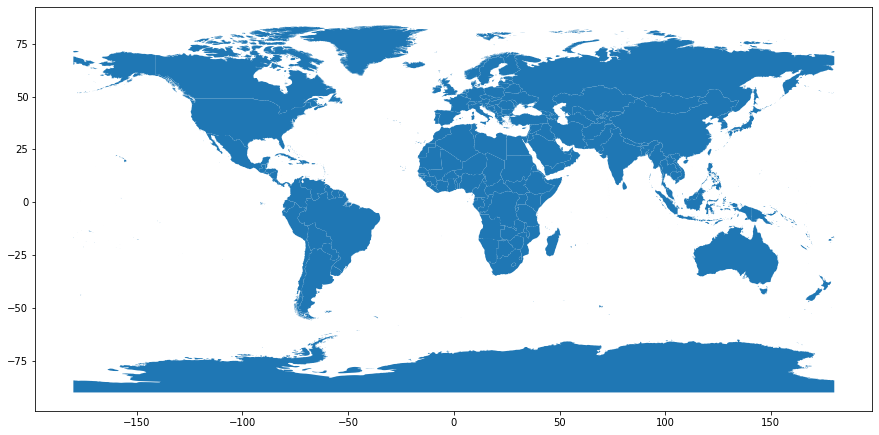

In [31]:
world_map = gpd.read_file('World_Countries.shp')
fig,ax = plt.subplots(figsize=(15,15))
world_map.plot(ax=ax)

In [32]:
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(geolocated['lon'],geolocated['lat'])]
geo_df = gpd.GeoDataFrame(geolocated,crs=crs,geometry=geometry)
geo_df.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,locat,lat,lon,geometry
0,USA,39.783730,-100.445882,POINT (-100.44588 39.78373)
1,UK,54.702354,-3.276575,POINT (-3.27658 54.70235)
2,India,22.351115,78.667743,POINT (78.66774 22.35111)
3,Australia,-24.776109,134.755000,POINT (134.75500 -24.77611)
4,Worldwide,52.480835,-1.914235,POINT (-1.91424 52.48083)


<AxesSubplot:>

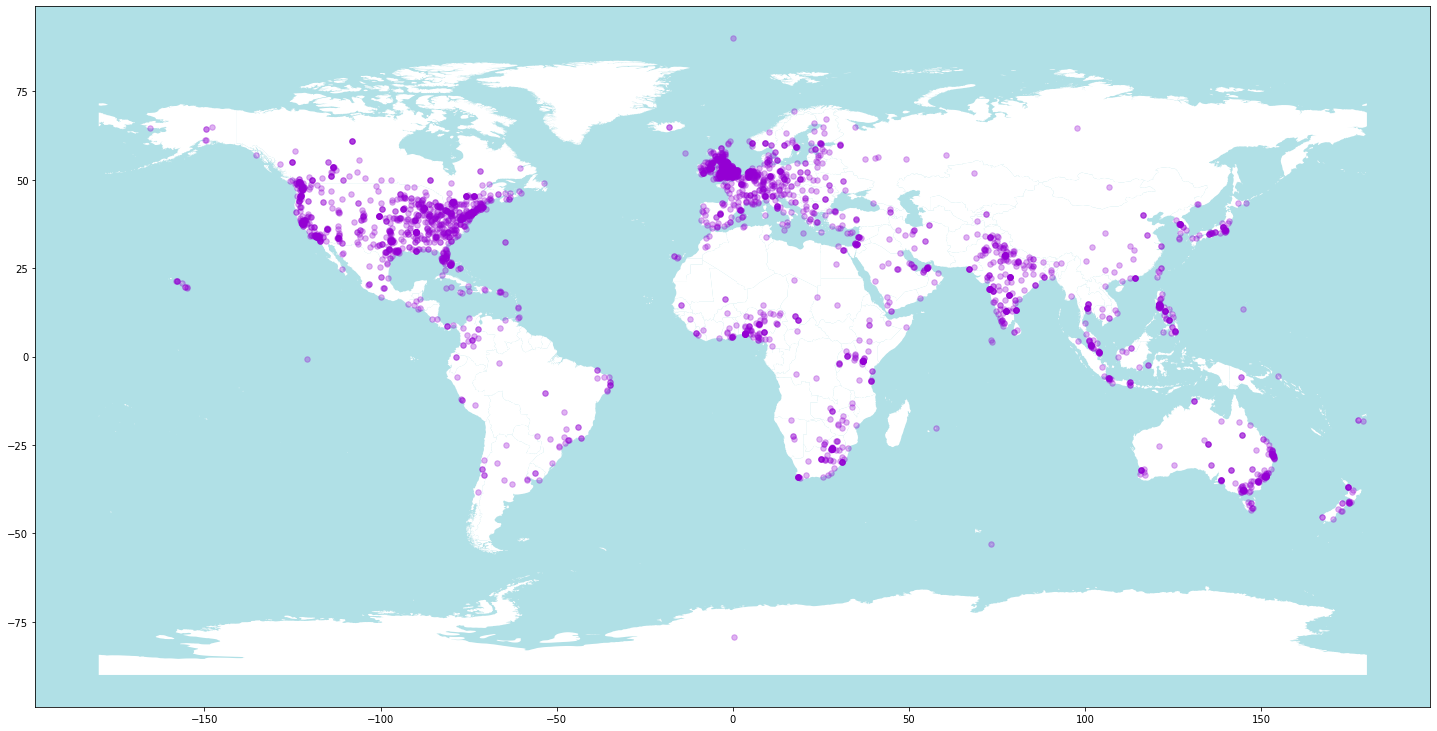

In [33]:
fig,ax = plt.subplots(figsize=(25,25))
ax.set(facecolor='Powderblue')
ax.set_alpha(0.2)
world_map.plot(ax=ax, alpha=1, color='white')
geo_df.plot(ax=ax,markersize=30,color='darkviolet',marker='o',alpha=0.3)

# Word cloud

In [34]:
import matplotlib as mpl
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [35]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.subplot.bottom'] = .1

In [36]:
#stopwords = set(STOPWORDS)

#wordcloud = WordCloud(
#                        background_color='white',
#                        stopwords=stopwords,
#                        max_words = 200,
#                        max_font_size = 40,
#                        random_state = 42,
#                        ).generate(str)


In [37]:
disaster_tweets=df[df['target']==1]['text']
nondisaster_tweets=df[df['target']==0]['text']

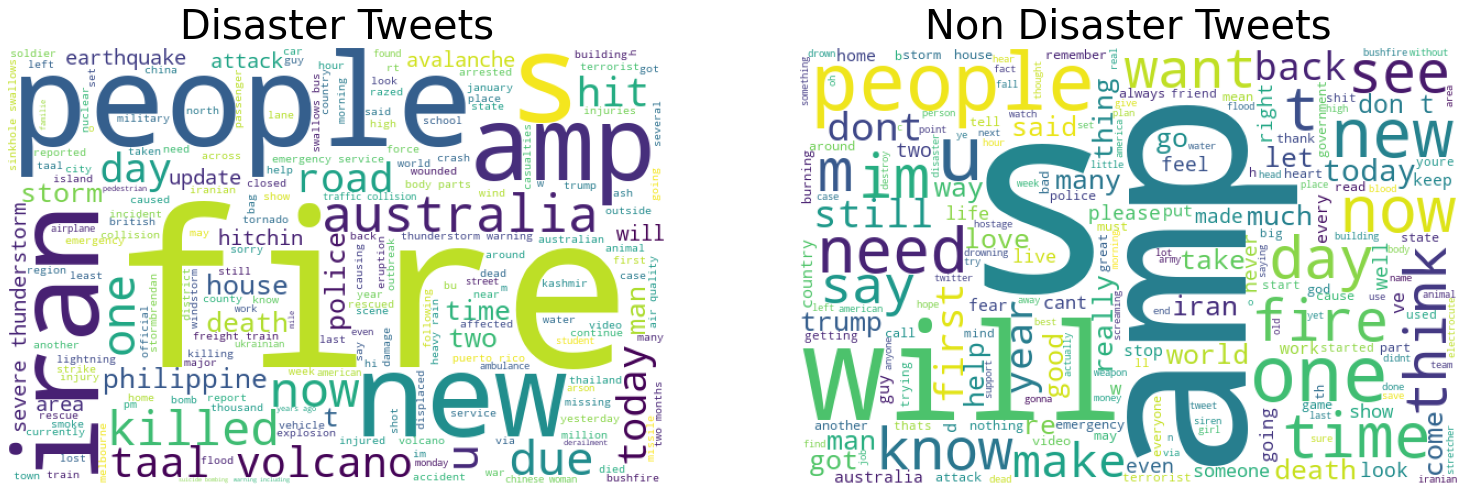

In [38]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))


ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(nondisaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

# Prediction Model

## We have more targets with 0 that means no disaster and less targets 1 meaning disaster
This could affect the resutls and accuracy in the trained model


<AxesSubplot:ylabel='target'>

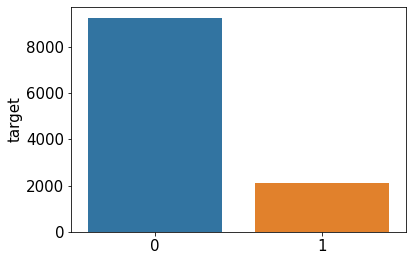

In [39]:
x = df['target'].value_counts().index
y = df['target'].value_counts()

sns.barplot(x=x ,y=y)

### We have a look on how does a Distaster and No Disaster Tweet looks like

In [40]:
# Now we see how a Disaster tweet looks like (Target 1)
disaster_tweets=df[df['target']==1]['text']
disaster_tweets.values[5]

'asansol a bjp office in salanpur village was set ablaze last night bjp has alleged that tmc is behind the incident police has b…'

In [41]:
# Now we see how a non Disaster tweet looks like (Target 0)
nondisaster_tweets=df[df['target']==0]['text']
nondisaster_tweets.values[10]

'warm greetings to all on the occasion of lohri as winter passes by may everyones woes and troubles be set ablaze in t…'

In [42]:
##Esta celda se va a quitar cuando esté todo el código, estoy limpiando aqui para hacer el ejercicio
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
df['text'] = df['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
df['text'].head()

id
0    communal violence in bhainsa telangana stones ...
1    telangana section  has been imposed in bhainsa...
2             arsonist sets cars ablaze at dealership 
3            arsonist sets cars ablaze at dealership  
4    lord jesus your love brings freedom and pardon...
Name: text, dtype: object

### Tokenizing 
Now we have to tokenize each Tweet, this mean that we have to split each sentence in words

In [43]:
#Tokenize the dataset
tokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
df['text']=df['text'].apply(lambda x:tokenizer.tokenize(x))
df['text'].head()

id
0    [communal, violence, in, bhainsa, telangana, s...
1    [telangana, section, has, been, imposed, in, b...
2       [arsonist, sets, cars, ablaze, at, dealership]
3       [arsonist, sets, cars, ablaze, at, dealership]
4    [lord, jesus, your, love, brings, freedom, and...
Name: text, dtype: object

###  Removing Stopwords
Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like, the, he, have etc.

In [ ]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


df['text'] = df['text'].apply(lambda x : remove_stopwords(x))
df.head()

### After the Stopwords we need to re join the whole text in to one string 

In [ ]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

df['text'] = df['text'].apply(lambda x : combine_text(x))
df.head()

### Spliting the data to train the model
We need to train our model with the same data set, but we need to assign in this case 80% to train and 20% of the same data to test it. This way we can see if the accuracy of our model

In [ ]:
# Splitting the data into independent and dependent features
X=df['text']
y=df['target']

In [ ]:
X.head()

### Here the ```test_size=0.2``` means that we are going to take the 20% of the data to test the model

In [ ]:
# We need data to train the model and data to test it. In this case we have 20% data to test
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2,random_state=1)

#Convert a collection of text documents to a matrix of token counts
vectorizer=CountVectorizer()
x_train_vectors=vectorizer.fit_transform(X_train)
x_test_vectors=vectorizer.transform(X_test)

In [ ]:
X_train.head()

In [ ]:
# We have a matrix with all the words converted to numbers
x_train_vectors.todense()

### Now we can see the metrics of our model
https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
clf_naive=MultinomialNB(alpha=0.2,fit_prior=False)
clf_naive.fit(x_train_vectors,y_train)
pred=clf_naive.predict(x_test_vectors)

accuracy_score_train=metrics.accuracy_score(y_train,clf_naive.predict(x_train_vectors))
print(f'Accuracy score train: {accuracy_score_train}')

accuracy_score_test=metrics.accuracy_score(y_test,pred)
print(f'Accuracy score test {accuracy_score_test}')
print('_____'*10+'\n')

classification_report_train=metrics.classification_report(y_train,clf_naive.predict(x_train_vectors))
print(f'-Classification report train:\n {classification_report_train}')

classification_report_test=metrics.classification_report(y_test,pred)
print(f'-Classification report test:\n {classification_report_test}')

roc_auc_score_train=metrics.roc_auc_score(y_train,clf_naive.predict(x_train_vectors))
print(f'Compute Area Under the Receiver Operating Characteristic Curve  train: {roc_auc_score_train}')

roc_auc_score_test=metrics.roc_auc_score(y_test,pred)
print(f'Compute Area Under the Receiver Operating Characteristic Curve test: {roc_auc_score_test}')

print('_____'*10+'\n')
confusion_matrix_train=metrics.confusion_matrix(y_train,clf_naive.predict(x_train_vectors))
print(f'Confusion Matrix Train:\n {confusion_matrix_train}')

confusion_matrix_test=metrics.confusion_matrix(y_test,pred)
print(f'Confusion Matrix Test:\n {confusion_matrix_test}')

## Conclusion

At the beginning the train and test score seems to be near to 1 with a good accuracy. Then on the classification report we can see that the precision is overfitted on the class '0' and if we see the support column there is a huge difference between bot targets, we have 7935 tweets with 0 and 1701 with 1. This mean that the model data is unbalanced.

https://muthu.co/understanding-the-classification-report-in-sklearn/